# Package installations and imports  

In [1]:
import torch
import torchvision
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
import torch.nn as nn
from torch.optim import Adam
import numpy as np
from tqdm import tqdm
from torchsummary import summary

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data Preparation

## Vegetable Dataset

From vegetable production to delivery, several common steps are operated manually like picking, and sorting vegetables. The initial experiment is done with 15 types of common vegetables that are found throughout the world. The vegetables that are chosen for the experimentation are- bean, bitter gourd, bottle gourd, brinjal, broccoli, cabbage, capsicum, carrot, cauliflower, cucumber, papaya, potato, pumpkin, radish and tomato. A total of 21000 images from 15 classes are used where each class contains 1400 images of size 224×224 and in *.jpg format. The dataset split 70% for training, 15% for validation, and 15% for testing purpose.

https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset

## Download and unzip the dataset

In [4]:
# train_set
!gdown https://drive.google.com/uc?id=1makfQYVHk5WS1MznDCnbYqwfDap2kVpY

# val_set
!gdown https://drive.google.com/uc?id=1TJa3_Exb1mUZzUvrDYsBzL1zzwJYywNP

# test_set
!gdown https://drive.google.com/uc?id=1e7TWjB5LOfihCwhV5jvLgxE85M43zTlH

Downloading...
From: https://drive.google.com/uc?id=1makfQYVHk5WS1MznDCnbYqwfDap2kVpY
To: /content/vegetable_train.zip
100% 399M/399M [00:02<00:00, 150MB/s]
Downloading...
From: https://drive.google.com/uc?id=1TJa3_Exb1mUZzUvrDYsBzL1zzwJYywNP
To: /content/vegetable_test.zip
100% 80.3M/80.3M [00:00<00:00, 85.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1e7TWjB5LOfihCwhV5jvLgxE85M43zTlH
To: /content/vegetable_validation.zip
100% 79.6M/79.6M [00:16<00:00, 4.72MB/s]


In [5]:
%%capture
!unzip /content/vegetable_train.zip;
!unzip /content/vegetable_validation.zip;
!unzip /content/vegetable_test.zip;

## Loading the train, val and test sets from their respective folders

### Initializing ImageFolder (dataset) Instances

In [6]:
image_size = 90
batch_size = 512

initialize train_set

In [7]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize((image_size,image_size))])

train_data_path = '/content/vegetable_train'

train_set = dummy_train_set = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
# dummy_train_set is initialized for keeping a copy of train_set 
# for demonstration of data augmentation

initialize val_set

In [ ]:
val_data_path = '/content/vegetable_validation'

val_set = torchvision.datasets.ImageFolder(root=val_data_path, transform=transform)

initialize test_set

In [ ]:
test_data_path = '/content/vegetable_test'

test_set = torchvision.datasets.ImageFolder(root=test_data_path, transform=transform)

### Attributes of the ImageFolder (dataset) objects (train_set)

In [ ]:
train_set

Dataset ImageFolder
    Number of datapoints: 15000
    Root location: /content/vegetable_train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(90, 90), interpolation=bilinear, max_size=None, antialias=None)
           )

In [ ]:
len(train_set.imgs)

15000

In [ ]:
# Class to num of instances
# caution: takes some time to run
class_counts = np.zeros(len(train_set.class_to_idx))
for image, label in train_set:
    class_counts[label] += 1
for i in range(len(class_counts)):
  print("class:%s, instances: %d"%([k for k,v in train_set.class_to_idx.items() if v == i], class_counts[i]))

class:['Bean'], instances: 1000
class:['Bitter_Gourd'], instances: 1000
class:['Bottle_Gourd'], instances: 1000
class:['Brinjal'], instances: 1000
class:['Broccoli'], instances: 1000
class:['Cabbage'], instances: 1000
class:['Capsicum'], instances: 1000
class:['Carrot'], instances: 1000
class:['Cauliflower'], instances: 1000
class:['Cucumber'], instances: 1000
class:['Papaya'], instances: 1000
class:['Potato'], instances: 1000
class:['Pumpkin'], instances: 1000
class:['Radish'], instances: 1000
class:['Tomato'], instances: 1000


## Function for visualizing images of dataset object 

In [ ]:
def show_dataset_samples(data_set):
    loader = torch.utils.data.DataLoader(
    data_set,
    batch_size=32,
    shuffle=True)

  # Get a batch of images from the train_loader
    images, labels = next(iter(loader))

    rows = col = 3
    #fig, axes = plt.subplots(nrows=5, ncols=5)                          )
    plt.figure(figsize = (10,10))

    for i in range(rows*col):
      # Plot a random image from the batch
      random_index = np.random.randint(0, images.shape[0])
      image = images[random_index]
      label = labels[random_index]
      plt.subplot(rows, col, i+1)
      plt.axis('off')
      plt.imshow(image.permute(1,2,0))
      plt.title(f'Label: {train_set.classes[label]}')

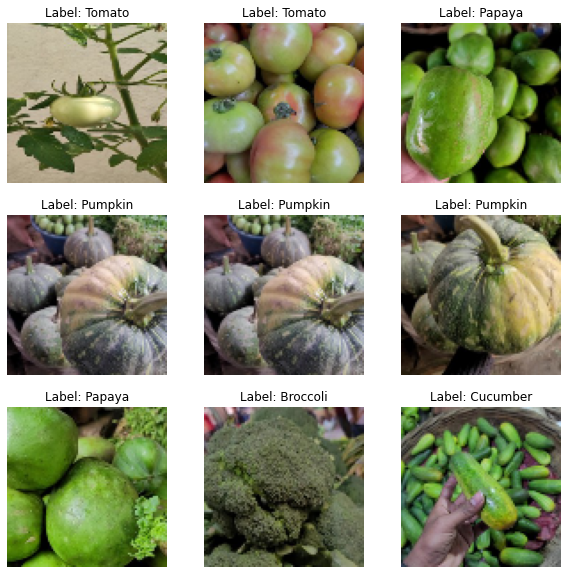

In [ ]:
show_dataset_samples(train_set)

## Compute Normalization parameters from the train_set and apply them to train, validation and test

### Compute Mean and Standard Deviation for train_set for each channel R, G and B

In [ ]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

# Source:
# https://towardsdatascience.com/how-to-calculate-the-mean-and-standard-deviation-normalizing-datasets-in-pytorch-704bd7d05f4c
# 

In [ ]:
dataset = torchvision.datasets.ImageFolder(root='/content/vegetable_train', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=32)

In [ ]:
mean, std = get_mean_and_std(dataloader)

In [ ]:
mean, std

(tensor([0.4689, 0.4635, 0.3433]), tensor([0.2327, 0.2274, 0.2420]))

### Add the new normalization to the existing transforms

In [ ]:
# Add the new normalization to the existing transforms
normalize = torchvision.transforms.Normalize(mean=mean, std=std)
transform = torchvision.transforms.Compose([transform, normalize])

# Apply the normalization transform to the datasets
train_set.transform = transform
val_set.transform = transform
test_set.transform = transform

In [ ]:
train_set.transform

### Visualize the images with the new normalization transform

In [ ]:
show_dataset_samples(train_set)

## Data Augmentation

1. RandomRotation
2. RandomFlip
  1. RandomHorizontalFlip
  2. RandomVerticalFlip
3. GaussianBlur 

Refer to the links below for a list of available pre-built data augmentation techniques and their illustrations that you can use.

https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

https://pytorch.org/vision/main/transforms.html

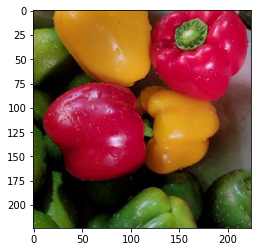

In [ ]:
orig_img = Image.open('/content/vegetable_train/Capsicum/0005.jpg')
plt.imshow(orig_img)

### Random Rotation

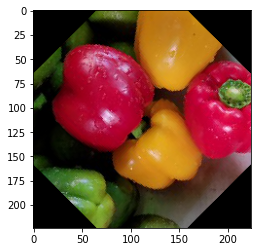

In [ ]:
random_rotation = torchvision.transforms.RandomRotation(45)
plt.imshow(random_rotation(orig_img))

### RandomFlip

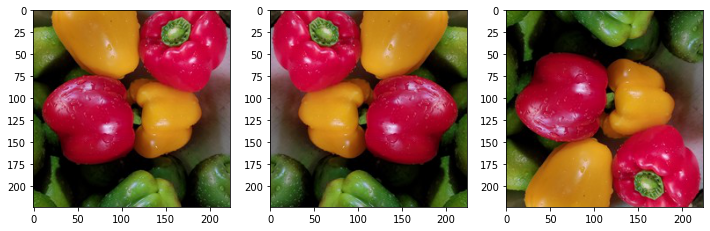

In [ ]:
plt.figure(figsize=(12,12))

plt.subplot(1,3,1)
plt.imshow(orig_img)

random_flip = torchvision.transforms.RandomHorizontalFlip(1)
plt.subplot(1,3,2)
plt.imshow(random_flip(orig_img))


random_flip = torchvision.transforms.RandomVerticalFlip(1)
plt.subplot(1,3,3)
plt.imshow(random_flip(orig_img))

### GaussianBlur

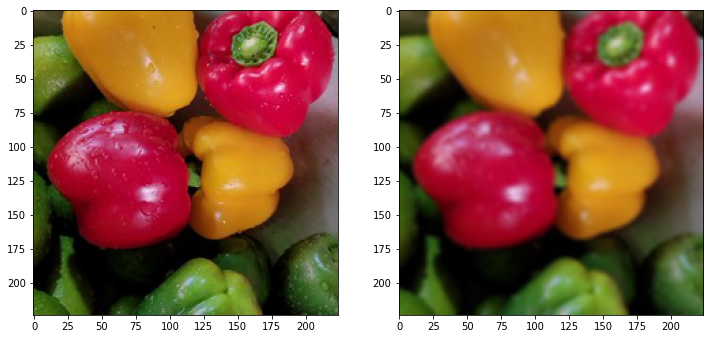

In [ ]:
plt.figure(figsize=(12,12))

plt.subplot(1,2,1)
plt.imshow(orig_img)

GB = torchvision.transforms.GaussianBlur(5,2)
plt.subplot(1,2,2)
plt.imshow(GB(orig_img))

### Applying all the augmentations combined

In [ ]:
augmentation_transforms = torchvision.transforms.Compose([transform,
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomRotation(degrees=45),
    torchvision.transforms.GaussianBlur(5)
    ])
train_set.transform = augmentation_transforms
train_set.transform

Compose(
    Compose(
    Compose(
    ToTensor()
    Resize(size=(90, 90), interpolation=bilinear, max_size=None, antialias=None)
)
    Normalize(mean=tensor([0.4689, 0.4635, 0.3433]), std=tensor([0.2327, 0.2274, 0.2420]))
)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0))
)

## Initializing the pytorch dataloaders and visualize train examples

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False
)


In [ ]:
# Get a batch of images from the train_loader
images, labels = next(iter(train_loader))

rows = col = 3
#fig, axes = plt.subplots(nrows=5, ncols=5)                          )
plt.figure(figsize = (10,10))

for i in range(rows*col):
  # Plot a random image from the batch
  random_index = np.random.randint(0, images.shape[0])
  image = images[random_index]
  label = labels[random_index]
  plt.subplot(rows, col, i+1)
  plt.axis('off')
  plt.imshow(image.permute(1,2,0))
  plt.title(f'Label: {train_set.classes[label]}')

# Convolutional Neural Networks

## The AlexNet Model (2012)

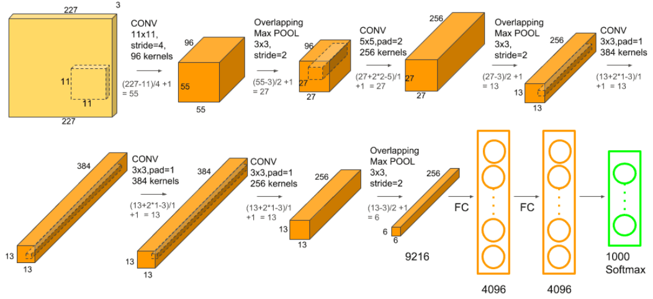

In [ ]:
# This model is designed such that it will take only image of size 227x227
# So set the image_size = 227 at the start to run this model
class AlexNet(nn.Module):
    def __init__(self, num_classes=15):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# Source: https://blog.paperspace.com/alexnet-pytorch/

In [ ]:
dummy_model = AlexNet().to(device)
summary(dummy_model, (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
       BatchNorm2d-2           [-1, 96, 55, 55]             192
              ReLU-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
       BatchNorm2d-6          [-1, 256, 27, 27]             512
              ReLU-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
      BatchNorm2d-10          [-1, 384, 13, 13]             768
             ReLU-11          [-1, 384, 13, 13]               0
           Conv2d-12          [-1, 384, 13, 13]       1,327,488
      BatchNorm2d-13          [-1, 384, 13, 13]             768
             ReLU-14          [-1, 384,

## VGG-16
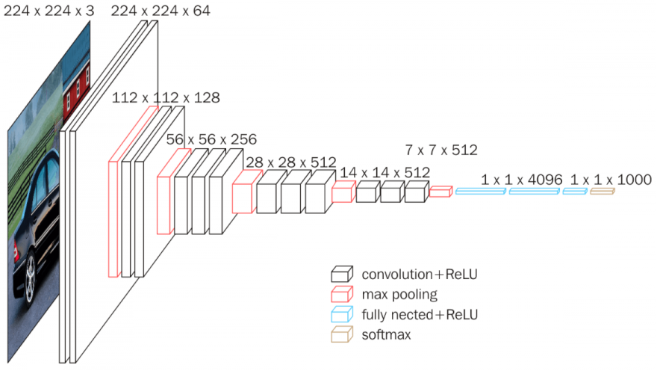

In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=15, im_height=224, im_width=224):
      
        super(VGG16, self).__init__()

        max_pool_count = 5
        size_reduction_factor = 2**max_pool_count
        out_height = im_height // size_reduction_factor
        out_width = im_width // size_reduction_factor

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(out_height*out_width*512, 4096),
            nn.ReLU())
        
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# Source: https://blog.paperspace.com/vgg-from-scratch-pytorch/

In [ ]:
dummy_model = VGG16(num_classes=15, im_height=image_size, im_width=image_size).to(device)
summary(dummy_model, (3, image_size, image_size))

## ResNet-18

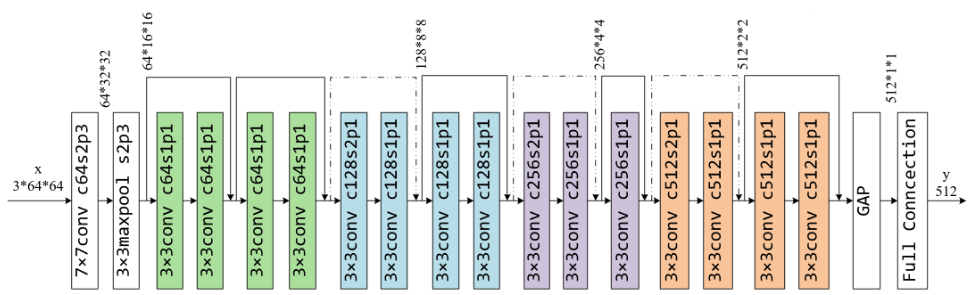

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)

In [ ]:
class ResNet18(nn.Module):
    def __init__(self, in_channels, resblock, outputs=15):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            resblock(64, 64, downsample=False),
            resblock(64, 64, downsample=False)
        )

        self.layer2 = nn.Sequential(
            resblock(64, 128, downsample=True),
            resblock(128, 128, downsample=False)
        )

        self.layer3 = nn.Sequential(
            resblock(128, 256, downsample=True),
            resblock(256, 256, downsample=False)
        )


        self.layer4 = nn.Sequential(
            resblock(256, 512, downsample=True),
            resblock(512, 512, downsample=False)
        )

        self.gap = torch.nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.fc = torch.nn.Linear(512, outputs)

    def forward(self, input):
        input = self.layer0(input)
        
        input = self.layer1(input)
        
        input = self.layer2(input)
        
        input = self.layer3(input)

        input = self.layer4(input)

        input = self.gap(input)

        input = self.flatten(input)
        #input = input.view(input.size(0), -1)

        input = self.fc(input)

        return input

#Source: https://towardsdev.com/implement-resnet-with-pytorch-a9fb40a77448

In [ ]:
resblock_class = ResBlock( 3, 4, True)

In [ ]:
resblock_class

ResBlock(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (shortcut): Sequential(
    (0): Conv2d(3, 4, kernel_size=(1, 1), stride=(2, 2))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
dummy_model = ResNet18(3, ResBlock, 15).to(device)
summary(dummy_model, (3, image_size, image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 45, 45]           9,472
         MaxPool2d-2           [-1, 64, 23, 23]               0
       BatchNorm2d-3           [-1, 64, 23, 23]             128
              ReLU-4           [-1, 64, 23, 23]               0
            Conv2d-5           [-1, 64, 23, 23]          36,928
       BatchNorm2d-6           [-1, 64, 23, 23]             128
            Conv2d-7           [-1, 64, 23, 23]          36,928
       BatchNorm2d-8           [-1, 64, 23, 23]             128
          ResBlock-9           [-1, 64, 23, 23]               0
           Conv2d-10           [-1, 64, 23, 23]          36,928
      BatchNorm2d-11           [-1, 64, 23, 23]             128
           Conv2d-12           [-1, 64, 23, 23]          36,928
      BatchNorm2d-13           [-1, 64, 23, 23]             128
         ResBlock-14           [-1, 64,

## The simple convolutional model from Lab 1

In [ ]:
num_classes = 15
model = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(8),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(16),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            Linear(32 * 5 * 5, num_classes)
        )

model.to(device);

In [ ]:
dummy_model = model.to(device)
summary(dummy_model, (3, image_size, image_size))

# Model Configuration

### Initialize AlexNet Model

In [ ]:
# Initialize the model
model = AlexNet(num_classes=15) 
model.to(device);

### Initialize VGG16 Model

In [ ]:
model = VGG16(num_classes=15, im_height= image_size, im_width= image_size)
model.to(device);

### Initialize ResNet18

In [ ]:
model = ResNet18(3, ResBlock, 15).to(device)

NameError: ignored

### Extra: A single layer model for faster experimentation

In [ ]:
# A dummy single layer model to quickly traverse training loops
num_classes = 15
model = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            nn.Flatten(),
            Linear(4 * image_size * image_size, num_classes)
        )

model.to(device);

## Loss Function and Optimizer Selection

In [ ]:
# Select a loss function
loss_function = torch.nn.CrossEntropyLoss()

# Select an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)
# For more on schedulers please visit:
# https://towardsdatascience.com/a-visual-guide-to-learning-rate-schedulers-in-pytorch-24bbb262c863

# Set the number of epochs
# This variable is used in the main training loop
epochs = 60


# Training

## Function for running the model over all the samples of a given dataloader object

In [ ]:
def run_1_epoch(model, loss_fn, loader, optimizer = None, train = False):
  
  
  if train:
    model.train()
  else:
    model.eval()


  total_correct_preds = 0
  
  total_loss = 0

  # Number of images we can get by the loader
  total_samples_in_loader = len(loader.dataset.imgs)
  
  # number of batches we can get by the loader 
  total_batches_in_loader = len(loader)
  
  

  for image_batch, labels in tqdm(loader):
    
    # Transfer image_batch to GPU if available
    image_batch = image_batch.to(device)
    labels = labels.to(device)
    
    # Zeroing out the gradients for parameters
    if train:
      assert optimizer is not None, "Optimizer must be provided if train=True"
      optimizer.zero_grad()
    
    # Forward pass on the input batch
    output = model(image_batch)

    # Acquire predicted class indices
    _, predicted = torch.max(output.data, 1) # the dimension 1 corresponds to max along the rows 
    
    # Removing extra last dimension from output tensor
    output.squeeze_(-1)

    # Compute the loss for the minibatch
    loss = loss_function(output, labels)
    
    # Backpropagation
    if train:
      loss.backward()
    
    # Update the parameters using the gradients
    if train:
      optimizer.step()
    
    # Extra variables for calculating loss and accuracy
    # count total predictions for accuracy calcutuon for this epoch
    total_correct_preds += (predicted == labels).sum().item()

    total_loss += loss.item()

  loss = total_loss / total_batches_in_loader
  accuracy = 100 * total_correct_preds / total_samples_in_loader

  return loss, accuracy 

## Run this for training from scratch

In [ ]:
# Initializing variables for starting a new training
# Some helper variables

train_accuracy_list = []
val_accuracy_list = []

train_loss_list = []
val_loss_list = []

val_accuracy_max = -1

checkpoint_path = 'checkpoint.pth'
best_val_model_path = 'best_val_model.pth'

# Start epoch is zero for new training
start_epoch = 0

## Run this to continue training for a saved model

In [ ]:
# Loading all variables for continuing trianing a previously saved model 

# Path to checkpoint
saved_checkpoint_path = '/content/checkpoint.pth'

# Load the checkpoint
checkpoint = torch.load(saved_checkpoint_path)

# Load all the state_dictionaries of the model, optimizer and schedular
model.load_state_dict(checkpoint['model'])

optimizer.load_state_dict(checkpoint['optimizer'])

scheduler.load_state_dict(checkpoint['scheduler'])

# Epoch to continue from the last training
start_epoch = checkpoint['trianed_epochs'] + 1

# Load the accuracy and loss lists for record keeping
train_accuracy_list = checkpoint['train_accuracies']
val_accuracy_list = checkpoint['val_accuracies']

train_loss_list = checkpoint['train_losses']
val_loss_list = checkpoint['val_losses']

# Load the value of the max val accuracy obtained in the previous training
# This will help us to avoid saving a new model with lower val accuracy 
# over the previously saved model with better val accuracy
val_accuracy_max = checkpoint['val_accuracy_max']

# paths to checkpoint and best val acc model
checkpoint_path = 'checkpoint.pth'
best_val_checkpoint_path = 'best_val_checkpoint.pth'

## Main training loop

In [ ]:
# Main training and validation loop for n number of epochs
for epoch in range(start_epoch, epochs):

  # Train model for one epoch

  # Get the current learning rate from the optimizer
  current_lr = optimizer.param_groups[0]['lr']

  print("Epoch %d: Train \nLearning Rate: %.6f"%(epoch, current_lr))
  train_loss, train_accuracy  = run_1_epoch(model, loss_function, train_loader, optimizer, train= True)

  # Update the learning rate scheduler
  scheduler.step()

  # Lists for train loss and accuracy for plotting
  train_loss_list.append(train_loss)
  train_accuracy_list.append(train_accuracy)

  # Validate the model on validation set
  print("Epoch %d: Validation"%(epoch))
  with torch.no_grad():
    val_loss, val_accuracy  = run_1_epoch(model, loss_function, val_loader, optimizer, train= False)
  
  # Lists for val loss and accuracy for plotting
  val_loss_list.append(val_loss)
  val_accuracy_list.append(val_accuracy)

  print('train loss: %.4f'%(train_loss))
  print('val loss: %.4f'%(val_loss))
  print('train_accuracy %.2f' % (train_accuracy))
  print('val_accuracy %.2f' % (val_accuracy))
  
  # Save model if validation accuracy for current epoch is greater than 
  # all the previous epochs 
  if val_accuracy > val_accuracy_max:
    val_accuracy_max = val_accuracy
    print("New max val Accuracy Acheived %.2f. Saving model.\n\n"%(val_accuracy_max))

    checkpoint = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_loss_list,
    'train_accuracies': train_accuracy_list,
    'val_losses': val_loss_list,
    'val_accuracies': val_accuracy_list,
    'val_accuracy_max': val_accuracy_max,
    'lr': optimizer.param_groups[0]['lr']
    }
    torch.save(checkpoint, best_val_checkpoint_path)

  else:
    print("val accuracy did not increase from %.2f\n\n"%(val_accuracy_max))

# Save checkpoint for the last epoch
  checkpoint = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_loss_list,
    'train_accuracies': train_accuracy_list,
    'val_losses': val_loss_list,
    'val_accuracies': val_accuracy_list,
    'val_accuracy_max': val_accuracy_max,
    'lr': optimizer.param_groups[0]['lr']
    }

  torch.save(checkpoint, checkpoint_path)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Copy best model to drive
# You may also directly save the best model to drive during training

!cp best_val_acc_model.pth /path/to/Gdrive

**Accuracy and Loss Result Graphs:**

In [ ]:
plt.figure()
plt.plot(train_accuracy_list, label="train_accuracy")
plt.plot(val_accuracy_list, label="val_accuracy")
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.title('Training and val Accuracy')

plt.figure()
plt.plot(train_loss_list, label="train_loss")
plt.plot(val_loss_list, label="val_loss")

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and val Loss')

# Evaluating the Model

**Loading the best saved model:**

In [ ]:
best_val_model_path = 'best_val_checkpoint.pth'
best_val_checkpoint = torch.load(best_val_model_path)

In [ ]:
# Before loading the state_dict of the model, make sure the "model" instance is 
# initiated by its corresponding class e.g. VGG16
model.load_state_dict(best_val_checkpoint['model'])

<All keys matched successfully>

In [ ]:
with torch.no_grad():
    test_loss, test_accuracy  = run_1_epoch(model, loss_function, test_loader, train= False)

print('test loss: %.4f'%(test_loss))
print('test_accuracy %.2f' % (test_accuracy))


100%|██████████| 6/6 [00:08<00:00,  1.46s/it]

test loss: 0.1924
test_accuracy 95.03


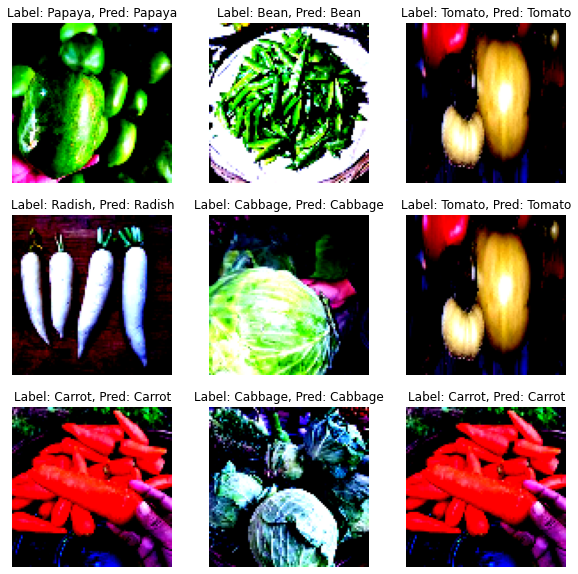

In [ ]:
# Get a batch of images from the train_loader
images, labels = next(iter(test_loader))

with torch.no_grad():
  predicted_labels = model(images.to(device))
  predicted_labels = torch.argmax(predicted_labels, 1)
rows = col = 3
#fig, axes = plt.subplots(nrows=5, ncols=5))
plt.figure(figsize = (10,10))

for i in range(rows*col):
  # Plot a random image from the batch
  random_index = np.random.randint(0, images.shape[0])
  image = images[random_index]
  label = labels[random_index]
  pred_label = predicted_labels[random_index]
  plt.subplot(rows, col, i+1)
  plt.axis('off')
  plt.imshow(image.permute(1,2,0))
  plt.title(f'Label: {test_set.classes[label]}, Pred: {test_set.classes[pred_label]}')

# Credits
Notebook Prepared by Bostan Khan, Team Lead, MachVIS Lab